# Módulo 6 - Técnicas de Programação II

### Plotagem de Gráficos na EDA

**Professora**:  
Patrícia Bongiovanni Catandi

**Alunos:**  
Matheus Lima  
José Venâncio  
Willker Menezes

## Importando Bibliotecas & Definindo Constantes

In [168]:
from typing import Dict, List
import os
import re
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

In [93]:
sns.set_theme()

In [94]:
DATA_INPUT_FOLDER = 'data'
ARCHIVE_FOLDER = 'archive'
OUTPUT_FOLDER = 'output'

## Importando os Dados

Extraídos da base: https://www.kaggle.com/datasets/patkle/metacritic-scores-for-games-movies-tv-and-music

Os dados são referentes a notas de jogos, filmes, músicas e séries (de TV) avaliados por usuários e pelo próprio domínio Metacritic.

In [95]:
# Um dicionário contendo os 4 DataFrames, separados 
df_dict : Dict[ str, pd.DataFrame ] = {}
for file_data in os.listdir(DATA_INPUT_FOLDER):
    df_dict[file_data[:-4]] = pd.read_csv(
        os.path.join( DATA_INPUT_FOLDER, file_data ),
        index_col=0,
        parse_dates= ['release_date'],
        dayfirst= True
    )

print(df_dict.keys())

dict_keys(['games', 'movies', 'music', 'tv'])


## Analizando Inicialmente a Base exclusiva de Jogos

### Visão Geral

In [96]:
games_df = df_dict['games']

# Observar informações gerais sobre os dados e tipos
display(games_df.info())
display(games_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20022 entries, 543718 to 213564
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   metascore     20022 non-null  int64         
 1   platform      20022 non-null  object        
 2   release_date  20022 non-null  datetime64[ns]
 3   sort_no       20022 non-null  int64         
 4   summary       19930 non-null  object        
 5   title         20022 non-null  object        
 6   user_score    20022 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 1.2+ MB


None

metascore       platform release_date  sort_no  \
id                                                       
543718         91             PC   2020-08-18      301   
555108         91             PC   2022-12-08      302   
106820         91  PlayStation 2   2005-11-07      303   
110775         91             PC   2008-11-13      304   
142864         91            Wii   2010-10-26      305   

                                                  summary  \
id                                                          
543718  From light planes to wide-body jets, fly highl...   
555108  Take up your sword, channel your magic or boar...   
106820  Strap on your Guitar Hero SG controller, plug-...   
110775  Players last visited Northrend in "Warcraft II...   
142864  Rock Band returns with the third iteration of ...   

                                            title user_score  
id                                                            
543718                 Microsoft Flight Simulator        7.1  
555108                             Chained Echoes        8.7  
106820                                Guitar Hero        8.5  
110775  World of Warcraft: Wrath of the Lich King        7.7  
142864                                Rock Band 3        6.8

O banco apresenta 20022 registros (linhas), com 7 propriedades (colunas):

- 'metascore': nota da plataforma
- 'platform': plataforma
- 'release_date': data de lançamento
- 'sort_no': número de ordenação
- 'summary': resumo - descrição breve do jogo
- 'title': título - nome do jogo
- 'user_score': nota dos usuários

Podemos verificar que 

- metascore é de 0 a 100 e está ocupando espaco de um int 64
- Há dados nulos (faltando) para o resumo (summary) de alguns registros
- Os dados de nota dos usuários (user_score) estão sendo tratados como texto (object) em vez de números (float)

In [97]:
# Utilizando método describe nas colunas categóricas:
games_df.describe(exclude='number', datetime_is_numeric=True)

platform                   release_date  \
count     20022                          20022   
unique       22                            NaN   
top          PC                            NaN   
freq       5276                            NaN   
mean        NaN  2012-05-03 03:56:19.922085632   
min         NaN            1995-04-30 00:00:00   
25%         NaN            2006-11-14 00:00:00   
50%         NaN            2012-06-25 12:00:00   
75%         NaN            2018-02-13 00:00:00   
max         NaN            2023-02-02 00:00:00   

                                                  summary          title  \
count                                               19930          20022   
unique                                              15545          12926   
top     Iron Man, an explosive third-person action sho...  Madden NFL 07   
freq                                                    7              9   
mean                                                  NaN            NaN   
min                                                   NaN            NaN   
25%                                                   NaN            NaN   
50%                                                   NaN            NaN   
75%                                                   NaN            NaN   
max                                                   NaN            NaN   

       user_score  
count       20022  
unique         94  
top           tbd  
freq         1382  
mean          NaN  
min           NaN  
25%           NaN  
50%           NaN  
75%           NaN  
max           NaN

**`platform`**

- Temos **22 plataformas diferentes** nos dados.

- A plataforma em que mais jogos estão presentes é o  **PC**, contando com  **5.276 registros** nos dados.

**`title`**

- Temos **12.926 títulos únicos nos dados**. Isso indica que dos 20.022 títulos totais, 7.096 deles podem ser o mesmo jogo porém em um registro diferente para cada plataforma em que esse jogo foi lançado.

## Entendendo o Significado dos Dados

### sort_no

Análise do número de ordenação (sort_no)

In [98]:
# Conferir se é único
np.any(games_df['sort_no'].duplicated())

False

In [99]:
# Conferir se tem alguma relação com outra coluna, principalmente de notas
games_df.sort_values('sort_no')

metascore       platform release_date  sort_no  \
id                                                       
160692         99    Nintendo 64   1998-11-23        1   
160779         98    PlayStation   2000-09-20        2   
108362         98  PlayStation 3   2008-04-29        3   
160751         98      Dreamcast   1999-09-08        4   
108363         98       Xbox 360   2008-04-29        5   
...           ...            ...          ...      ...   
507544         17         Switch   2017-04-05    20018   
111627         17  PlayStation 3   2009-05-05    20019   
111235         17       Xbox 360   2007-10-10    20020   
112727         16             PC   2013-06-24    20021   
213564         11          Wii U   2012-12-04    20022   

                                                  summary  \
id                                                          
160692  As a young boy, Link is tricked by Ganondorf, ...   
160779  As most major publishers' development efforts ...   
108362  [Metacritic's 2008 PS3 Game of the Year; Also ...   
160751  This is a tale of souls and swords, transcendi...   
108363  [Metacritic's 2008 Xbox 360 Game of the Year; ...   
...                                                   ...   
507544  Vroom in the night sky is a magical bike actio...   
111627  The Leisure Suit Larry: Box Office Bust video ...   
111235  [Xbox Live Arcade]  Hop into a Toyota Yaris an...   
112727  The game is set in the last years of the roari...   
213564  Family Party: 30 Great Games Obstacle Arcade b...   

                                               title user_score  
id                                                               
160692          The Legend of Zelda: Ocarina of Time        9.1  
160779                      Tony Hawk's Pro Skater 2        7.4  
108362                           Grand Theft Auto IV        7.8  
160751                                   SoulCalibur        8.4  
108363                           Grand Theft Auto IV          8  
...                                              ...        ...  
507544                        Vroom in the Night Sky        3.3  
111627           Leisure Suit Larry: Box Office Bust        1.9  
111235                                         Yaris        4.4  
112727                     Ride to Hell: Retribution        1.4  
213564  Family Party: 30 Great Games Obstacle Arcade        2.7  

[20022 rows x 7 columns]

In [100]:
# comparar se a ordenação pelo metascore (decrescente) e pelo sort_no (crescente) tem mesmas notas metascore
np.all(
    games_df.sort_values('metascore', ascending= False, ignore_index= True)['metascore'] == 
    games_df.sort_values('sort_no', ignore_index= True)['metascore']
)

True

Logo concluímos que sort_no é uma ordenação de ranking com base nos maiores metascore

## Levantando Hipóteses e Questionamentos

1. Qual o top 10 jogos mais bem avaliados pelo site? E pelos usuários?
2. Qual a plataforma que mais aparece entre os 100 melhores avaliados pelos usuários?
3. As notas dos jogos melhoraram a cada ano? E para cada plataforma ao longo dos anos?
4. Tem alguma epoca do ano que apresenta maior sucesso em relação a notas maiores?
5. Que palavras mais aparecem nos títulos dos 1000 melhores jogos? E dos 100 piores? E nos resumos?
6. Histograma - Distribuição de Lançamento de Jogos por Ano
7. Histograma - Distribuição de Lançamento de Jogos por Mês
8. Histograma - Distribuição da avaliação dos usuários
9. Histograma - Distribuição da avaliação do Metacritic
10. Heatmap - Correlação entre as variáveis
11. Qual o número de games produzidos para cada plataforma do Dataset? Esses valores indicam qual porcentagem do total?
12. Comparativo: PlayStation 4 e PlayStation 5
13. Games Disponíveis por Mês por 7 anos (PS4 e Previsão PS5)
14. Qual a proporção de cada tipo de classificação atribuída aos games? Qual a porcentagem do total de cada uma?
15. Distribuição de Classificações Metacritic
16. Quais são os top 10 games mais bem avaliados pelos usuários e pelo metacritic? Eles são muito diferentes?
17. Quais são os bottom 10 games pior avaliados pelos usuários e pelo metacritic? Eles são muito diferentes?

## Limpando dados

### metascore (número de bytes)

In [101]:
# int8 vai de -128 a 128, contemplando todos os valores
games_df = ( games_df.astype({'metascore': 'int8'}) )

### user_score

In [102]:
# tentativa de converter o tipo dos dados de user_score, para ver os valores que falham
set_errors = set()
for score in games_df['user_score']:
    try:
        float(score)
    except Exception as e:
        set_errors.add(str(e))
print(set_errors)

{"could not convert string to float: 'tbd'"}


In [103]:
# Entendendo os registros com nota tbd (To Be Determined, traduzido como "a ser determinado")
display( games_df[ games_df['user_score'] == 'tbd' ].head() )
print(f"Número de registros com nota dos usuários pendente: { np.sum( games_df['user_score'] == 'tbd' ) }")
print(f"Porcentagem de registros com nota dos usuários pendente: { np.sum( games_df['user_score'] == 'tbd' ) / len( games_df ) :0.1%}")

metascore          platform release_date  sort_no  \
id                                                          
610248         87     Xbox Series X   2022-11-11     1095   
526629         86            Switch   2022-04-07     1324   
162449         86              Xbox   2004-08-31     1363   
161810         86  Game Boy Advance   2002-12-05     1568   
559845         85            Switch   2023-01-19     1983   

                                                  summary  \
id                                                          
610248  It has been five decades since a small team in...   
526629  Seamlessly blending both the arcade action of ...   
162449  Do you have what it takes to be a top NASCAR d...   
161810                                                NaN   
559845  A Space For The Unbound is a slice-of-life adv...   

                                        title user_score  
id                                                        
610248  Atari 50: The Anniversary Celebration        tbd  
526629                        The Last Friend        tbd  
162449         NASCAR 2005: Chase for the Cup        tbd  
161810                     Moto Racer Advance        tbd  
559845                A Space For The Unbound        tbd

Número de registros com nota dos usuários pendente: 1382
Porcentagem de registros com nota dos usuários pendente: 6.9%


Uma possível explicação para esse valor é de que esse número é uma média e ainda não tiveram avaliações de usuários o suficiente para computar uma média adequada.

Alternativas:
- substituir os valores pela média geral
- separar em grupos de acordo com algum critério e substituir os valores pelas médias de cada grupo 
    - mesmo metascore
    - mesma plataforma
    - mesmo metascore e plataforma
- substituir os valores usando técnicas que mantenham a distribuição dos dados válidos
    - bfill (backward fill) : substituir pela proxima observacao
    - ffill (forward fill) : substituir pela observacao anterior
- excluir linhas

Como esses dados representam 7% dos valores, fizemos uma média de acordo o agrupamento pela plataforma.

In [104]:
# para comparação
games_df['user_score_raw'] = games_df['user_score']

# Transformar a coluna em float, e os valores faltantes em NaN para poder computar a média
games_df['user_score'] = games_df['user_score'].replace('tbd', np.nan).astype(float)

# Criar uma cópia do dataframe, para alterar o user_score somente na cópia
games_df['user_score'] = games_df['user_score'].fillna(
    games_df.groupby('platform')['user_score'].transform('mean')
)

display( games_df[['user_score', 'user_score_raw']].head() )
display( games_df[games_df['user_score_raw'] == 'tbd'][['platform', 'user_score', 'user_score_raw']].head(10) )

games_df = games_df.drop(columns= 'user_score_raw')

user_score user_score_raw
id                               
543718         7.1            7.1
555108         8.7            8.7
106820         8.5            8.5
110775         7.7            7.7
142864         6.8            6.8

platform  user_score user_score_raw
id                                                 
610248     Xbox Series X    6.539901            tbd
526629            Switch    7.053772            tbd
162449              Xbox    7.254235            tbd
161810  Game Boy Advance    7.579718            tbd
559845            Switch    7.053772            tbd
196912          Xbox 360    6.880514            tbd
590193                PC    6.863584            tbd
618789                PC    6.863584            tbd
161553              Xbox    7.254235            tbd
161433  Game Boy Advance    7.579718            tbd

### summary

In [105]:
print('número de resumos faltantes:', games_df['summary'].isna().sum() )
display( games_df[games_df['summary'].isna()].head() )

número de resumos faltantes: 92


metascore          platform release_date  sort_no summary  \
id                                                                  
522348         88     PlayStation 4   2018-03-27      883     NaN   
161810         86  Game Boy Advance   2002-12-05     1568     NaN   
522819         86            Switch   2018-08-30     1635     NaN   
208732         85                PC   2012-04-09     1755     NaN   
513073         83                PC   2017-09-22     2581     NaN   

                                 title  user_score  
id                                                  
522348  Injustice 2: Legendary Edition    7.700000  
161810              Moto Racer Advance    7.579718  
522819                      Mini Metro    8.000000  
208732     Out of the Park Baseball 13    7.800000  
513073      Guild Wars 2: Path of Fire    7.300000

Parece ser um caso de dados não coletados, pois a falta de um texto no csv gera um NaN

Alternativas:

- procurar os dados na internet e preencher manualmente
- substituir por um valor padrão
- deixar como está
- excluir linhas

Como é uma descrição do jogo, não há necessidade em perder os outros dados por conta dele.

Substituímos os valores por uma string vazia, assim como está em games.csv

In [106]:
games_df['summary'] = games_df['summary'].fillna('')
games_df['summary'].isna().sum()

0

## Criando Novas Variáveis

### Trimestre de Lançamento

Como forma de expandir nossas possibilidades de análise, vamos inserir nos dados uma nova variável que informa qual o trimestre do ano em que o Jogo foi lançado.

In [107]:
def set_year_quarter(data: pd.DataFrame) -> pd.DataFrame:
    '''Retorna uma nova variável que informa o trimestre do ano em que
    o jogo foi lançado. Essa definição de trimestre se baseia no mês de lançamento
    da coluna release_date.
    
    PARÂMETROS:
    
        data > DataFrame para se aplicar a alteração.
    '''
    data['release_quarter'] = data['release_date'].apply(
        lambda value:
            'Q1' if value.month in [1, 2, 3] else
            'Q2' if value.month in [4, 5, 6] else
            'Q3' if value.month in [7, 8, 9] else
            'Q4' if value.month in [10, 11, 12] else
            value
            )
    
    return data

In [108]:
# Aplicando função:
games_df = set_year_quarter(games_df)

# Checando resultado:
games_df.sample(10)

metascore       platform release_date  sort_no  \
id                                                       
160701         87      Dreamcast   2001-01-15     1068   
545829         71         Switch   2019-08-13    11028   
162667         88       GameCube   2005-02-22      984   
112684         63             DS   2008-11-26    15335   
162674         87       GameCube   2005-02-28     1283   
584080         72  PlayStation 5   2021-12-15    10618   
110293         79             DS   2007-11-27     5574   
599981         62             PC   2023-01-12    15643   
161878         73       GameCube   2004-02-18     9650   
526686         69             PC   2019-05-31    12347   

                                                  summary  \
id                                                          
160701  Enter a new age of driving, a new form of thin...   
545829  Exception is a combat platformer set inside a ...   
162667  MVP Baseball 2005 offers more features that le...   
112684  In Cradle of Rome, players can build more than...   
162674  The sequel to EA Sports' Fight Night 2004 main...   
584080  Aeterna Noctis is a challenging 2D Metroidvani...   
110293  Geometry Wars: Galaxies delivers an all new mi...   
599981  LONE RUIN is a spell-based roguelike twin-stic...   
161878  Delving deep in the Peruvian Jungle, you assum...   
526686  In a world ravaged by war and dominated by mag...   

                               title  user_score release_quarter  
id                                                                
160701       Metropolis Street Racer    8.800000              Q1  
545829                     Exception    7.053772              Q3  
162667             MVP Baseball 2005    7.700000              Q1  
112684                Cradle of Rome    7.156537              Q4  
162674           Fight Night Round 2    7.400000              Q1  
584080                Aeterna Noctis    7.900000              Q4  
110293       Geometry Wars: Galaxies    7.600000              Q4  
599981                     Lone Ruin    6.863584              Q1  
161878  Pitfall: The Lost Expedition    8.000000              Q1  
526686          Warhammer: Chaosbane    4.900000              Q2

### Subdivisões da Variável release_date

Com a nova variável de trimestre de lançamento criada, vamos retornar as atenções a variável 'release_date' e utilizá-la para criar três variáveis distintas que informam apenas o dia, mês e ano do lançamento.

Essa divisão da variável 'release_date' será feita para facilitar a criação de plots na etapa de análises.

- Criando variável 'release_day':

In [109]:
# Criando nova variável:
games_df['release_day'] = games_df['release_date'].dt.day

- Criando variável 'release_month':

In [110]:
games_df['release_month'] = games_df['release_date'].dt.month

- Criando variável 'release_year':

In [111]:
# Criando nova variável:
games_df['release_year'] = games_df['release_date'].dt.year

In [112]:
games_df.head(5)

metascore       platform release_date  sort_no  \
id                                                       
543718         91             PC   2020-08-18      301   
555108         91             PC   2022-12-08      302   
106820         91  PlayStation 2   2005-11-07      303   
110775         91             PC   2008-11-13      304   
142864         91            Wii   2010-10-26      305   

                                                  summary  \
id                                                          
543718  From light planes to wide-body jets, fly highl...   
555108  Take up your sword, channel your magic or boar...   
106820  Strap on your Guitar Hero SG controller, plug-...   
110775  Players last visited Northrend in "Warcraft II...   
142864  Rock Band returns with the third iteration of ...   

                                            title  user_score release_quarter  \
id                                                                              
543718                 Microsoft Flight Simulator         7.1              Q3   
555108                             Chained Echoes         8.7              Q4   
106820                                Guitar Hero         8.5              Q4   
110775  World of Warcraft: Wrath of the Lich King         7.7              Q4   
142864                                Rock Band 3         6.8              Q4   

        release_day  release_month  release_year  
id                                                
543718           18              8          2020  
555108            8             12          2022  
106820            7             11          2005  
110775           13             11          2008  
142864           26             10          2010

### Metascore_class

Essa variável tem como objetivo abrigar a classificação dos valores do Metascore. De acordo com um [FAQ do próprio site](https://www.metacritic.com/about-metascores), para cada range de notas temos uma classificação geral atribuída a ele como ilustrado na imagem abaixo retirada diretamente do FAQ:

<img src="https://raw.githubusercontent.com/JoSEPHDev2022/Metacritc_Scores_Video_Games/main/images/metascore_classification.png" width=700 height=350>

https://www.metacritic.com/about-metascores

In [113]:
def set_metascore_class(data: pd.DataFrame) -> pd.DataFrame:
    '''Retorna uma nova variável que consta a classificação do Jogo
    com base em sua nota. Essas classificações são:
    
        - "Universal Acclaim" para games com notas entre 90 e 100;
        - "Generally Favorable Reviews" para games com notas entre 75 e 89;
        - "Mixed or Average Reviews" para games com notas entre 50 e 74;
        - "Generally Unfavorable Reviews" para games com notas entre 20 e 49;
        - "Overwhelming Dislike" para games com notas entre 0 e 19.

        PARÂMETROS:
        
        data > DataFrame para se aplicar a alteração. 
    '''
    data['classification'] = data['metascore'].apply(
        lambda value:
            'Universal Acclaim' if 90 <= value <= 100 else
            'Generally Favorable' if 75 <= value <= 89 else
            'Mixed or Average' if 50 <= value <= 74 else
            'Generally Unfavorable' if 20 <= value <= 49 else
            'Overwhelming Dislike'   
            )
    
    return data

In [114]:
# Aplicando função:
games_df = set_metascore_class(games_df)

In [115]:
# Visualizando resultados:
games_df.sample(10)

metascore       platform release_date  sort_no  \
id                                                       
115334         74       Xbox 360   2009-06-17     8654   
531479         74  PlayStation 4   2019-05-28     8987   
215565         71  PlayStation 3   2014-04-29    11352   
506827         77             PC   2018-01-30     7036   
109770         41       Xbox 360   2007-12-04    19577   
234328         78            3DS   2013-10-01     6235   
161042         73           Xbox   2002-03-18     9763   
112346         78             DS   2008-11-04     6229   
211071         41             PC   2013-07-03    19582   
107623         84  PlayStation 2   2006-02-20     2264   

                                                  summary  \
id                                                          
115334  [Xbox Live Arcade]  Sam & Max Save the World i...   
531479  Stack, raid, and GET PAID. The dungeon-diving ...   
215565  JoJo's Bizarre Adventure: All-Star Battle give...   
506827  Remothered: Tormented Fathers is the pure and ...   
109770  The Golden Compass follows the screenplay adap...   
234328  Rune Factory 4 marks the return of the popular...   
161042  In Gun Valkyrie players suit up as either Kell...   
112346  The single player game follows Goku and his cl...   
211071  DARK is a stealth action game with RPG element...   
107623  Go toe-to-toe with greats such as Ali, De La H...   

                                            title  user_score release_quarter  \
id                                                                              
115334                  Sam & Max: Save the World         7.2              Q2   
531479                          Lapis x Labyrinth         5.0              Q2   
215565  JoJo's Bizarre Adventure: All-Star Battle         8.1              Q2   
506827              Remothered: Tormented Fathers         7.8              Q1   
109770                         The Golden Compass         4.3              Q4   
234328                             Rune Factory 4         8.1              Q4   
161042                                Gunvalkyrie         6.5              Q1   
112346                       Dragon Ball: Origins         7.8              Q4   
211071                                       DARK         4.2              Q3   
107623                        Fight Night Round 3         8.1              Q1   

        release_day  release_month  release_year         classification  
id                                                                       
115334           17              6          2009       Mixed or Average  
531479           28              5          2019       Mixed or Average  
215565           29              4          2014       Mixed or Average  
506827           30              1          2018    Generally Favorable  
109770            4             12          2007  Generally Unfavorable  
234328            1             10          2013    Generally Favorable  
161042           18              3          2002       Mixed or Average  
112346            4             11          2008    Generally Favorable  
211071            3              7          2013  Generally Unfavorable  
107623           20              2          2006    Generally Favorable

In [190]:
fig = px.scatter(games_df, x="release_date", y="metascore", animation_frame="platform", 
                 animation_group="title", size="user_score", color="classification",
                 hover_name="title", range_y=[0,100])

fig.update_layout(title_text='Evolução das notas de jogos por plataforma e gênero')

fig.show()

## Funções auxiliares

Com objetivo de estudar palavras presentes na descrição e título, criamos uma função que realiza a extração das palavras

In [116]:
def extract_words(texto : str) -> List[str]:
    return re.findall('\w+', texto)

extract_words('Injustice 2: Legendary Edition')

['Injustice', '2', 'Legendary', 'Edition']

In [117]:
def count_words(serie_texto : pd.Series) -> Dict[str, int]:
    '''
    It counts the number of text elements from the input series which contain a certain word
    @input:
        - serie_texto: a string-type pd.Series
    @output:
        A dict where each key is a word and the value its count as described
    '''
    word_counter = Counter()
    for texto in serie_texto:
        word_counter.update( Counter( set( extract_words(texto) ) ) )
    return word_counter

count_words(pd.Series(['Injustice 2: Legendary Edition', 'Injustice 2: Legendary Edition', 'Mini Metro']))

Counter({'Edition': 2,
         '2': 2,
         'Injustice': 2,
         'Legendary': 2,
         'Mini': 1,
         'Metro': 1})

## EDA

### Análise Univariada

In [118]:
games_df.columns

Index(['metascore', 'platform', 'release_date', 'sort_no', 'summary', 'title',
       'user_score', 'release_quarter', 'release_day', 'release_month',
       'release_year', 'classification'],
      dtype='object')

#### Ánalise de Variável Categórica: platform

<AxesSubplot: >

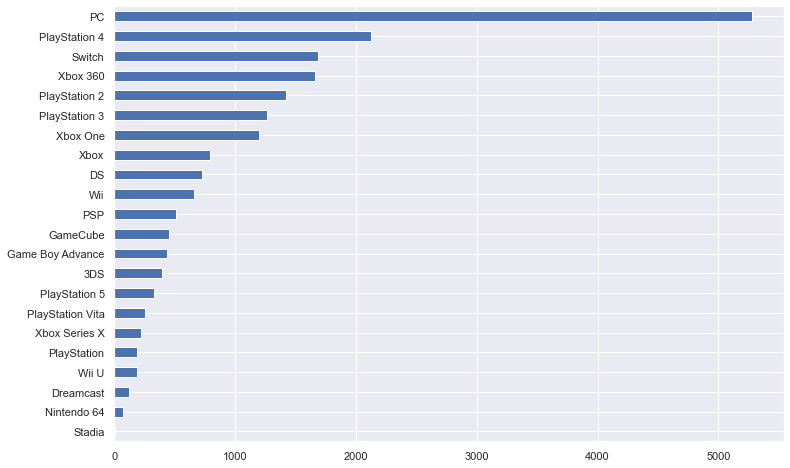

In [119]:
plt.figure(figsize=(12, 8))
games_df['platform'].value_counts(ascending= True).plot.barh()

Há muitas plataformas, e muitas estão relacionadas pelo 'fabricante', entao criaremos outra coluna

<AxesSubplot: >

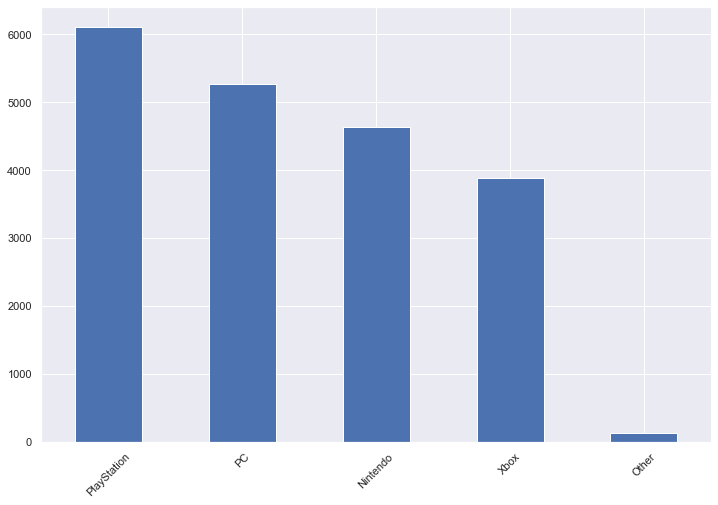

In [120]:
plt.figure(figsize=(12, 8))
platform_manufacturer = {
    'PC' : 'PC',
    'PlayStation' : 'PlayStation',
    'PlayStation 5' : 'PlayStation',
    'PlayStation 4' : 'PlayStation',
    'PlayStation 3' : 'PlayStation',
    'PlayStation 2' : 'PlayStation',
    'PlayStation Vita' : 'PlayStation',
    'PSP' : 'PlayStation',
    'Nintendo 64' : 'Nintendo',
    'GameCube' : 'Nintendo',
    'Wii U' : 'Nintendo',
    'Wii' : 'Nintendo',
    'Switch' : 'Nintendo',
    'Game Boy Advance' : 'Nintendo',
    'DS' : 'Nintendo',
    '3DS' : 'Nintendo',
    'Xbox Series X' : 'Xbox',
    'Xbox' : 'Xbox',
    'Xbox One' : 'Xbox',
    'Xbox 360' : 'Xbox',
    'Xbox 360' : 'Xbox',
    'Stadia' : 'Other',
    'Dreamcast' : 'Other'
}
games_df['manufacturer'] = games_df['platform'].map(platform_manufacturer)
games_df['manufacturer'].value_counts().plot.bar(rot= 45)

Assim podemos ver que a PlayStation na verdade ultrapassa o número de jogos de PC no total,
considerando que ela renova o console de tempos em tempos

In [121]:
# Nova análise das variáveis numéricas após a criação das novas colunas
games_df.describe()

metascore       sort_no    user_score   release_day  release_month  \
count  20022.000000  20022.000000  20022.000000  20022.000000   20022.000000   
mean      70.758566  10011.500000      6.968037     16.531415       7.000499   
std       12.165042   5779.997881      1.312430      8.630879       3.346318   
min       11.000000      1.000000      0.300000      1.000000       1.000000   
25%       64.000000   5006.250000      6.400000      9.000000       4.000000   
50%       72.000000  10011.500000      7.200000     17.000000       8.000000   
75%       80.000000  15016.750000      7.900000     24.000000      10.000000   
max       99.000000  20022.000000      9.700000     31.000000      12.000000   

       release_year  
count  20022.000000  
mean    2011.795475  
std        6.493958  
min     1995.000000  
25%     2006.000000  
50%     2012.000000  
75%     2018.000000  
max     2023.000000

In [165]:
# Agrupando os dados por plataforma e fabricante
grouped_data = games_df.groupby(['platform', 'manufacturer'], as_index=False)['title'].count()

# Plotandoo gráfico
fig = px.sunburst(grouped_data, path=['manufacturer', 'platform'], values='title')

fig.update_layout(
    title='Distribuição de jogos por fabricante e plataforma',
    margin=dict(t=50, l=0, r=0, b=0),
    font=dict(size=14),
)


fig.show()

## Histogramas: analisando variáveis numéricas continuas

### Função auxiliar

In [122]:
# Definindo uma função para plotagem dos histogramas pelo MatPlotLib:

def histogram_plot(data: pd.DataFrame, column: pd.Series, bin_width: float, title: str):
    '''Retorna um Histograma detalhado sobre os dados fornecidos.
    
    PARÂMETROS:

        - data > Um DataFrame do Pandas contendo os dados;
        - column > Uma Series do Pandas contendo os dados desejados para plotagem;
        - bin_width: > Número float para a dimensão das barras do histograma;
        - title > O título desejado para o plot.
    '''
    fig, ax1 = plt.subplots(figsize=(12,6))

    ax2 = sns.histplot(data=data, 
                       x=column, 
                       kde=True,
                       label='Frequência', 
                       binwidth=bin_width,
                       edgecolor='black', 
                       line_kws={'linestyle': 'dashdot'},
                       color='#151bbf')
    
    ax2.set_title(title, fontdict={'size': 15, 
                                   'weight': 'bold'})
    
    ax2.set_ylabel('Num. Registros', fontdict={'size': 12,
                                               'family': 'monospace'})

    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda number, char: format(int(number), ',')))

    ax2.set_xlabel('')

##### release_year

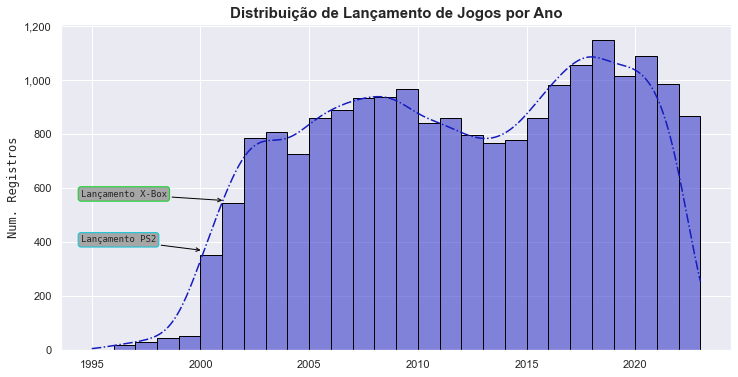

In [123]:
# Histograma:
histogram_plot(games_df, 
               'release_year', 
               1, 
               'Distribuição de Lançamento de Jogos por Ano')

# Anotando lançamento PS2:
plt.annotate('Lançamento PS2', 
             fontsize=9, 
             fontfamily='monospace',
             xy=(2000.1, 370), 
             xytext=(1994.5,400), 
             arrowprops={'arrowstyle':'->', 'color':'black'},
             bbox={'boxstyle': 'round', 'fc': '0.65', 'color': '#0bc3d4'})

# Anotando lançamento X-Box:
plt.annotate('Lançamento X-Box', 
             fontsize=9, 
             fontfamily='monospace',
             xy=(2001.1, 555), 
             xytext=(1994.5,570), 
             arrowprops={'arrowstyle':'->', 'color':'black'},
             bbox={'boxstyle': 'round', 'fc': '0.65', 'color': '#0bd422'})

plt.show()

Centralidade

- Em relação aos anos de lançamento dos jogos, temos uma tendência central entre 2015 e 2020, onde as maiores quantidades de data points se acumulam.

Amplitude

In [124]:
amplitude = games_df['release_year'].max() - games_df['release_year'].min()

print(f'Período de {amplitude} anos.')

Período de 28 anos.


##### release_month

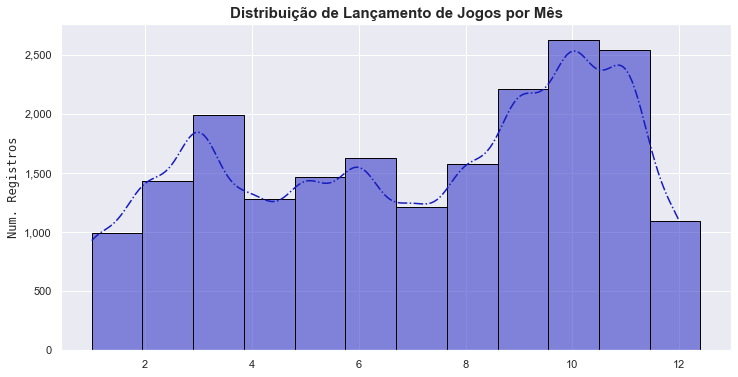

In [125]:
# Histograma:
histogram_plot(games_df, 
               'release_month',
               0.95,
               'Distribuição de Lançamento de Jogos por Mês')

Centralidade

- Em relação aos meses de lançamento dos jogos, temos uma tendência central mais ao final do ano, a partir de Setembro (9) a Novembro (11).

Amplitude

In [126]:
amplitude = games_df['release_month'].max() - games_df['release_month'].min() 

print(f'Intervalo de Tempo de {amplitude} meses.')

Intervalo de Tempo de 11 meses.


##### user_score

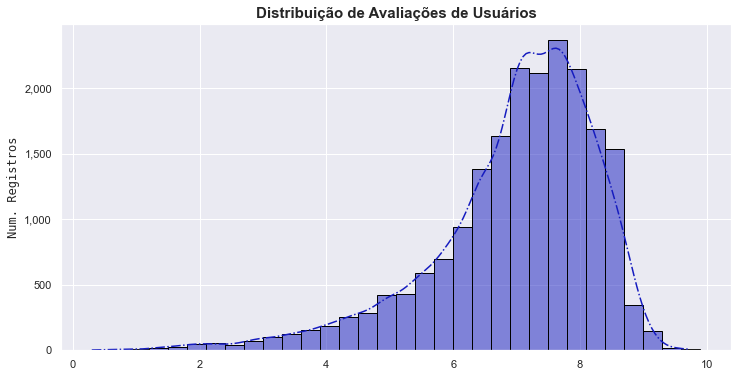

In [127]:
# Histograma:
histogram_plot(games_df, 
               'user_score',
               0.3,
               'Distribuição de Avaliações de Usuários')

Centralidade

- Em relação as notas fornecidas pelos usuários, temos uma tendência central dos dados entre 7 e 8, como a mediana de 7.1 nos apontou anteriormente.

Amplitude

- Temos uma amplitude pequena por se tratar de uma avaliação, indo de 0 a 10.

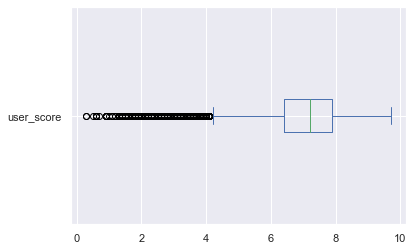

In [128]:
_= games_df['user_score'].plot.box(vert= False)

Os dados da coluna 'user_score' apresentam muitos outliers à esquerda (valores baixos) e mais da metade dos jogos está avaliado no intervalo de 6 a 8.

##### metascore

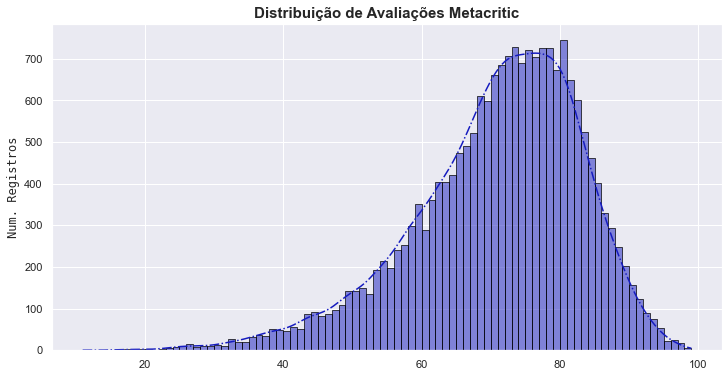

In [129]:
# Histograma:
histogram_plot(games_df, 
               'metascore',
               1,
               'Distribuição de Avaliações Metacritic')

Centralidade

- Em relação as notas fornecidas pelo Metacritic, temos uma tendência central dos dados entre 70 e 80. A distribuição de notas do Metacritic parece seguir o mesmo padrão das notas fornecidas pelos usuários, o que demonstra que as notas fornecidas pelo site não são tão discrepantes em relação as fornecidas pelos usuários. A correlação exata dessas duas métricas de avaliação será estudada mais a frente.

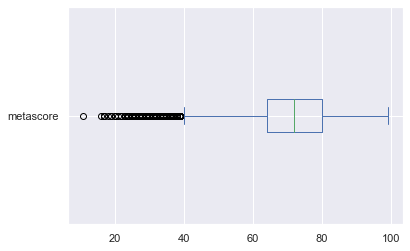

In [130]:
_= games_df['metascore'].plot.box(vert= False)

Os dados da coluna 'metascore' também apresentam muitos outliers a esquerda (valores baixos)
e mais da metade dos jogos está avaliado no intervalo de 60 a 80, bem semelhante ao user_score, considerando as escalas.

### Análise Bivariada

#### Correlação entre as variáveis

In [131]:
# Criando matriz de correlações:

correlation_matrix = games_df.select_dtypes(include=[np.number]).corr()

correlation_matrix

metascore   sort_no  user_score  release_day  release_month  \
metascore       1.000000 -0.956100    0.495320     0.003920       0.011761   
sort_no        -0.956100  1.000000   -0.456550    -0.002941      -0.015284   
user_score      0.495320 -0.456550    1.000000     0.023532       0.015504   
release_day     0.003920 -0.002941    0.023532     1.000000      -0.109514   
release_month   0.011761 -0.015284    0.015504    -0.109514       1.000000   
release_year    0.096349 -0.084102   -0.227469    -0.024127      -0.122418   

               release_year  
metascore          0.096349  
sort_no           -0.084102  
user_score        -0.227469  
release_day       -0.024127  
release_month     -0.122418  
release_year       1.000000

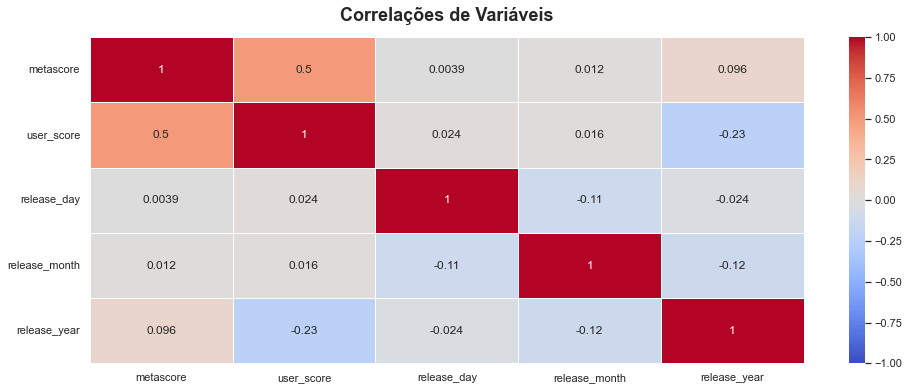

In [132]:
# Selecionando as colunas relevantes (excluindo 'sort_no')
cols = [col for col in games_df.columns if col != 'sort_no']
subset_df = games_df[cols]

# Calculando a matriz de correlação
correlation_matrix = subset_df.corr(numeric_only=True)

# Criando o Heatmap:
fig, ax = plt.subplots(figsize=(16, 6))

ax = sns.heatmap(correlation_matrix, 
                 vmin=-1, 
                 vmax=1, 
                 annot=True, 
                 linewidths=1, 
                 cmap='coolwarm')

# Formatação:
plt.title('Correlações de Variáveis', fontdict={'size': 18, 'weight': 'bold'}, pad=16)

plt.show()

<font color='#039c0b'>**Correlação igual a 1**</font>

- Correlação positiva perfeita. Quando o valor de uma variável X aumenta, o valor de outra variável Y também aumenta.

<font color='#039c0b'>**Correlação acima de 0**</font>

- Correlação positiva. Quando o valor de uma variável X aumenta, o valor de outra variável Y tende a aumentar, porém essa regra não é absoluta, tendo valores da variável Y que não se alteram ou diminuem.

**Correlação igual a 0**

- Não existe correlação entre as duas variáveis.

<font color='#a80505'>**Correlação menor que 0**</font>

- Correlação negativa. Quando o valor de uma variável X aumenta, o valor de outra variável Y tende a diminuir, porém essa regra não é absoluta, tendo valores da variável Y que não se alteram ou aumentam.

<font color='#a80505'>**Correlação igual a -1**</font>

- Correlação neagtiva perfeita. Quando o valor de uma variável X aumenta, o valor de outra variável Y diminui.

A correlação positiva entre **user_score** e **metascore** era esperada, apesar de não ser tão forte (>0.8). O que significa que há uma divergência entre as notas dadas pelo site e pelos usuários.

A correlação entre **metascore** e **sort_no** é negativa, indicando que jogos mais recentes tendem a ter pontuações mais baixas na crítica.

Outra correlação que aparece, apesar de fraca, é negativa entre o **user_score** e **release_year**. Isso quer dizer que quanto mais novos os jogos, menores as notas dos usuários.

#### user_score e metascore

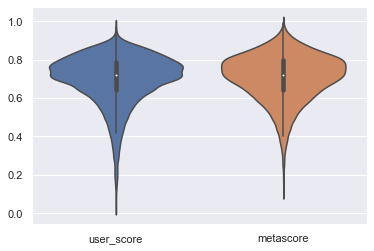

In [133]:
def scale_scores(row : pd.DataFrame) -> pd.DataFrame:
    row['metascore'] /= 100
    row['user_score'] /= 10
    return row

_= sns.violinplot( games_df[['user_score', 'metascore']].apply(scale_scores, axis= 1) )

Ambos tem comportamento parecido na distribuição, porém devemos olhar a relação dos pares para cada jogo em específico para melhor avaliar a relação

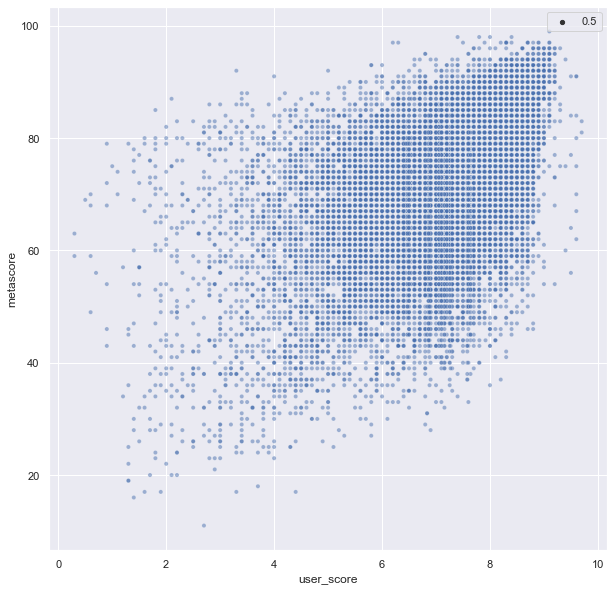

In [204]:
plt.figure(figsize= (10,10)) # importante deixar quadradro para uma comparaçao justa
_= sns.scatterplot(games_df, x= 'user_score', y= 'metascore', size= 0.5, alpha= 0.5)

É visível que, apesar da forte tendencia de que jogos com notas altas no metascore sejam bem avaliados pelos usuários, existem muitos casos bem avaliados pelo site, porém com nota bem baixa dos usuários, e vice-versa. Fizemos essa análise mais adiante.

#### user_score e release_year

(0.0, 10.0)

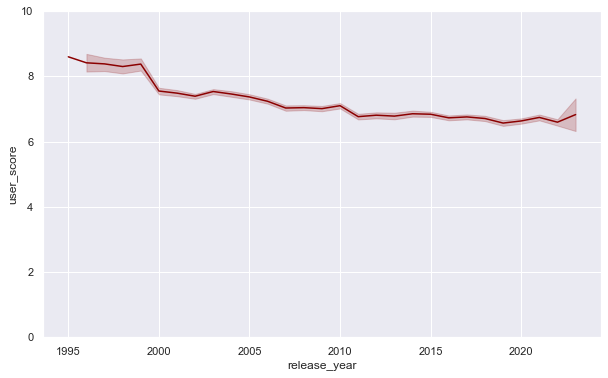

In [205]:
plt.figure(figsize=(10,6))
_= sns.lineplot(games_df, x= 'release_year', y= 'user_score', color= 'darkred')
plt.ylim(0, 10)

Ao longo do tempo, a média das notas dos usuários tem caído. Isso nos leva a pensar se a qualidade dos jogos tem piorado, se os usuários estão mais críticos, ou outras hipóteses como: será que o volume de jogos aumentou muito e também a diversidade dos estilos, o que não agrada a todos e decai as notas?

### Análise Multivariável 

#### Padrões nos jogos conforme a avaliação


In [136]:
games_df['classification_hue'] = games_df['classification'].map({
    'Universal Acclaim' : 'best',
    'Generally Favorable' : 'average',
    'Mixed or Average' : 'average',
    'Generally Unfavorable' : 'worst',
    'Overwhelming Dislike' : 'worst'
})

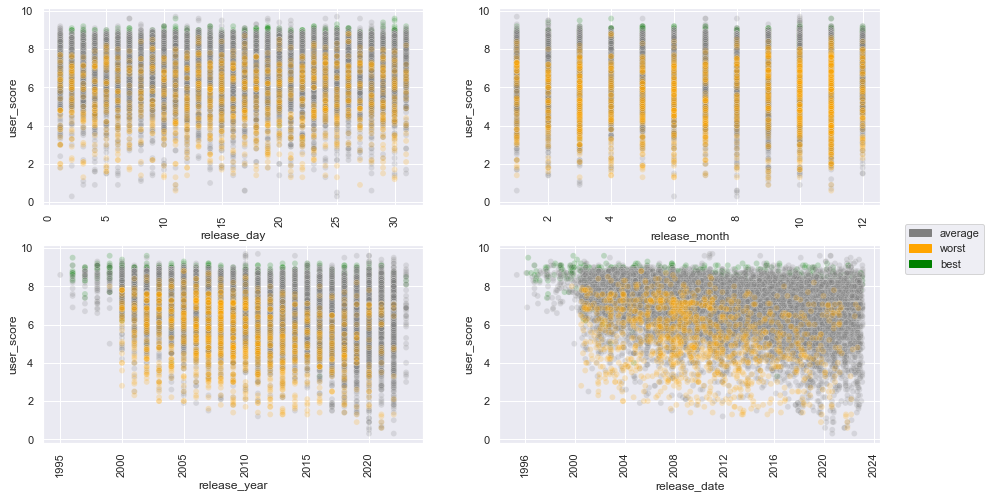

In [137]:
import matplotlib.patches as mpatches

# removendo sort_no e metascore do gráfico ja que classification é baseada neles 
fig, axes = plt.subplots(2, 2, figsize= (15,8))
axes = axes.flatten()

for datetime_col, ax in zip(
        ['release_day', 'release_month', 'release_year', 'release_date'],
        axes
    ): 
    sns.scatterplot(
        games_df,
        ax= ax,
        x= datetime_col,
        y= 'user_score',
        hue= 'classification_hue',
        hue_order= ['best', 'average', 'worst'],
        palette= {'average' : 'grey', 'worst' : 'orange', 'best' : 'green'},
        alpha= 0.2
    )
    ax.tick_params(axis='x', rotation=90)
    legend = ax.get_legend()
    legend.remove()

handles = []
for hue, color in {'average' : 'grey', 'worst' : 'orange', 'best' : 'green'}.items():
    patch = mpatches.Patch(color= color, label= hue)
    handles.append(patch)
_= fig.legend(handles= handles, loc= 'center right')

Note que antes de 2000 os jogos eram muito bem avaliados pelos usuários, e também é uma região que concentra muitos pontos verdes

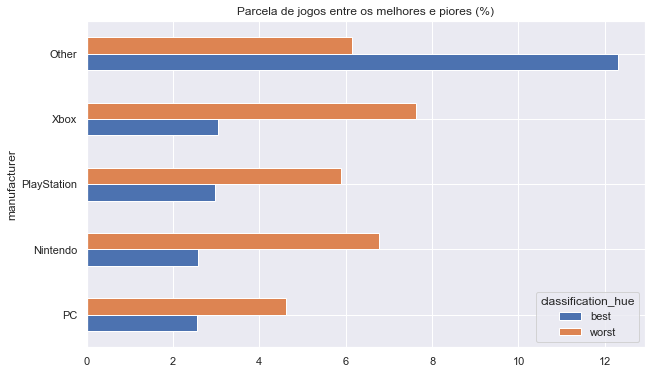

In [196]:
_= games_df.groupby(['classification_hue', 'manufacturer'], as_index= False)['title'].count().pivot(
    index='manufacturer', columns='classification_hue', values='title'
).apply(
    lambda row : 100 * row / row.sum(),
    axis= 1
)[ ['best', 'worst'] ].sort_values('best').plot.barh(
    title= 'Parcela de jogos entre os melhores e piores (%)',
    figsize=(10, 6)
)

Desconsiderando o novo grupo 'Other', os outros não apresentam diferenças significativas entre eles considerando os melhores jogos. Até os piores a diferença é pequena, mas claramente 'PC' não apresentam tantos jogos ruin como o Xbox em termos percentuais.

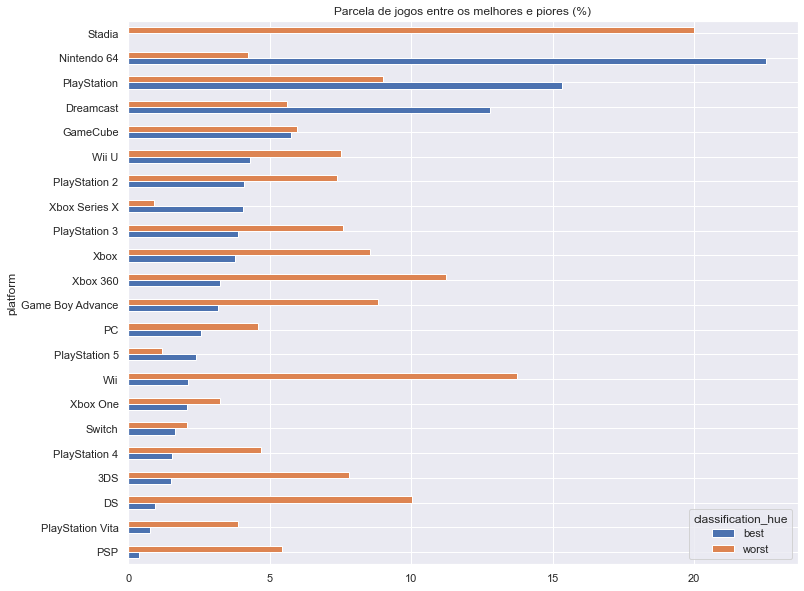

In [139]:
_= games_df.groupby(['classification_hue', 'platform'], as_index= False)['title'].count().pivot(
    index='platform', columns='classification_hue', values='title'
).apply(
    lambda row : 100 * row / row.sum(),
    axis= 1
)[ ['best', 'worst'] ].sort_values('best').plot.barh(
    title= 'Parcela de jogos entre os melhores e piores (%)',
    figsize=(12, 10)
)

Aqui observa-se um obvio sucesso nos jogos da NIntendo 64 e do PS1 e Dreamcast quando comparados as outras plataformas em percentual.

### Analisando Hipoteses E Respondendo Questionamentos

#### H1 - Qual o top 10 jogos mais bem avaliados pelo site? E pelos usuários?

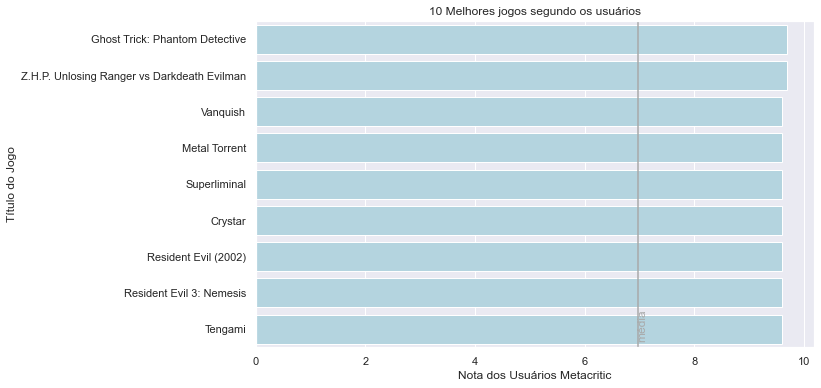

In [140]:
h1_games_df = games_df[['title', 'user_score']].sort_values(by='user_score', ascending=False).head(10)

plt.figure(figsize=(10,6))
ax = sns.barplot(data=h1_games_df, y='title', x='user_score', orient='h', color='lightblue')
ax.set_title('10 Melhores jogos segundo os usuários')
ax.set_ylabel('Título do Jogo')
ax.set_xlabel('Nota dos Usuários Metacritic')
ax.axvline(games_df['user_score'].mean(), color= 'darkgrey') 
ax.text(games_df['user_score'].mean(), 8.3, 'média', rotation= 'vertical', color= 'darkgrey')
plt.show()

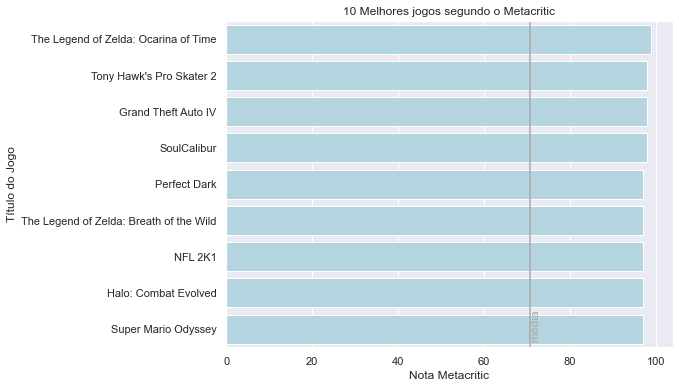

In [141]:
h1_games_df = games_df[['title', 'metascore']].sort_values(by='metascore', ascending=False).head(10)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=h1_games_df, y='title', x='metascore', orient='h', color='lightblue')
ax.set_title('10 Melhores jogos segundo o Metacritic')
ax.set_ylabel('Título do Jogo')
ax.set_xlabel('Nota Metacritic')
ax.axvline(games_df['metascore'].mean(), color= 'darkgrey') 
ax.text(games_df['metascore'].mean(), 8.3, 'média', rotation= 'vertical', color= 'darkgrey')
plt.show()

In [142]:
pd.merge(
    games_df.sort_values(by='user_score', ascending=False).head(10),
    games_df.sort_values(by='metascore', ascending=False).head(10)
)

Empty DataFrame
Columns: [metascore, platform, release_date, sort_no, summary, title, user_score, release_quarter, release_day, release_month, release_year, classification, manufacturer, classification_hue]
Index: []

Nenhum em comum

#### H2 - Qual a plataforma que mais aparece entre os 100 melhores avaliados pelos usuários?

In [143]:
h2_games_df = games_df.sort_values(by='user_score', ascending=False).head(100).groupby('platform').count()['user_score'].sort_values(ascending=False).reset_index()

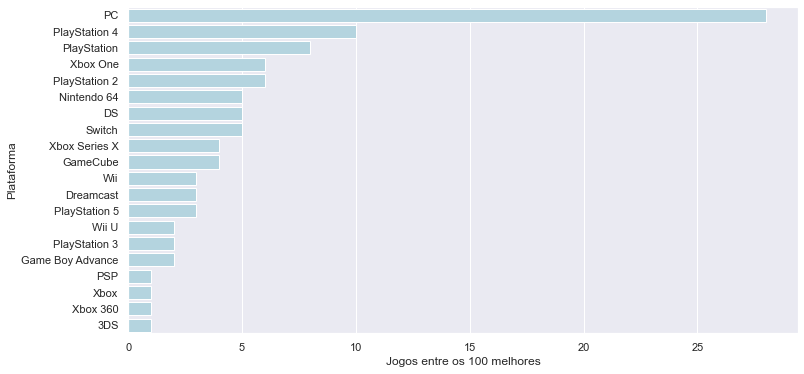

In [144]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=h2_games_df, y='platform', x='user_score', orient='h', color= 'lightblue')
ax.set_ylabel('Plataforma')
ax.set_xlabel('Jogos entre os 100 melhores')
plt.show()

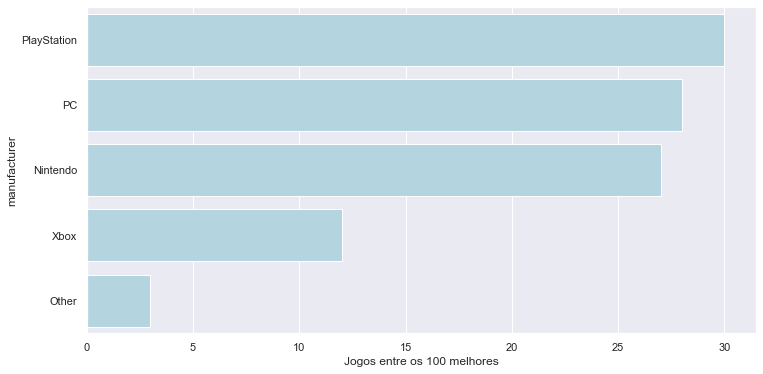

In [145]:
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data= games_df.sort_values(
            by='user_score', ascending=False
        ).head(100).groupby('manufacturer', as_index= False)['user_score'].count().sort_values(
            by='user_score', ascending=False
        ),
    y='manufacturer', 
    x='user_score', 
    orient='h', 
    color= 'lightblue')
ax.set_xlabel('Jogos entre os 100 melhores')
plt.show()

Considerando a junção dos jogos de PS, eles ultrapassam ligeiramente os jogos de PC, e os da Nintendo também se aproximam bastante.

#### H3 - As notas dos jogos melhoraram a cada ano? E para cada plataforma ao longo dos anos?

In [200]:
h3_df1 = games_df.groupby(['release_year'],as_index=False)[['metascore']].mean()
h3_df2 = games_df.groupby(['release_year'],as_index=False)[['user_score']].mean()

h3_games_df = pd.concat([h3_df1, h3_df2], ignore_index=True)
h3_games_df.reset_index(inplace=True, drop=True)
h3_games_df['score'] = np.where(h3_games_df['metascore'].isna() == True, h3_games_df['user_score'], h3_games_df['metascore']/10)
h3_games_df['source'] = np.where(h3_games_df['metascore'].isna() == True, 'user_score', 'metascore')
h3_games_df.drop(columns=['metascore', 'user_score'], inplace=True)

### Flutuação da pontuação dos usuários e da crítica de acordo com o ano de lançamento

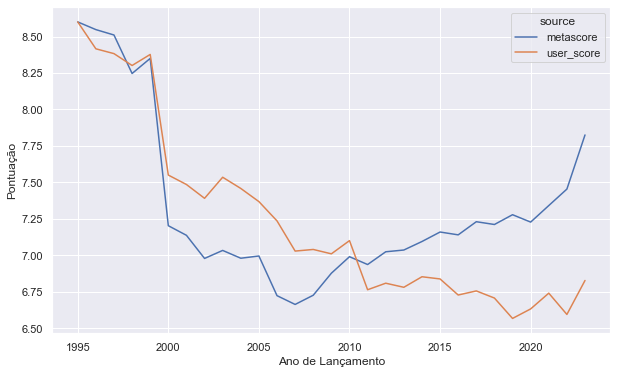

In [147]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=h3_games_df, x='release_year', y='score', hue='source', errorbar = None)
ax.set_xlabel('Ano de Lançamento')
ax.set_ylabel('Pontuação')
plt.show()

### Flutuação da pontuação dos usuários de acordo com o ano de lançamento, por plataforma

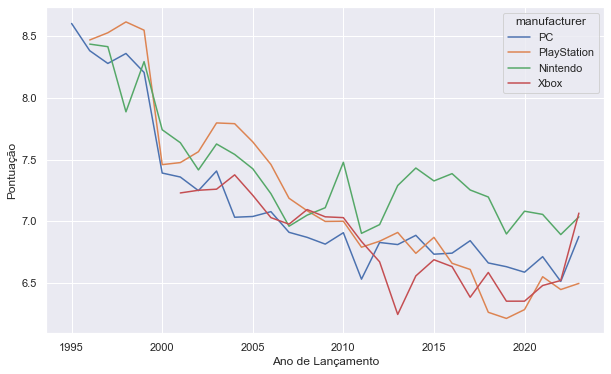

In [148]:
# usaremos a nota dos usuários como parametro
plt.figure(figsize=(10,6))
ax = sns.lineplot(
    data= games_df.drop(games_df[games_df['manufacturer'] == 'Other'].index), 
    x='release_year', 
    y='user_score', 
    hue='manufacturer', 
    errorbar=None
)
ax.set_xlabel('Ano de Lançamento')
ax.set_ylabel('Pontuação')
plt.show()

A média de todos tem caído. Nos ultimos 10 anos, observa-se que apenas a nintendo mantém um patamar minimo das médias, enquanto o restante decai menos, porém continua diminuindo.

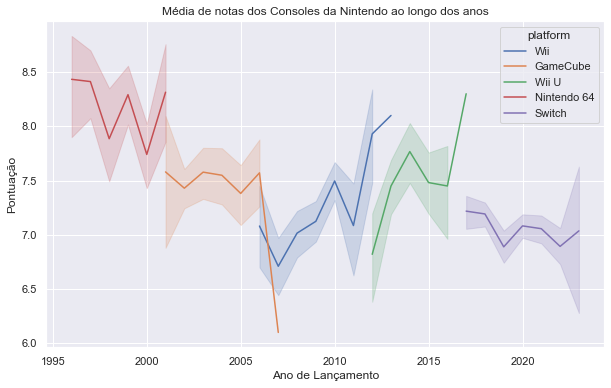

In [149]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(
    data= games_df.query('''
        platform in ("Nintendo 64", "GameCube", "Wii", "Wii U", "Switch")
    '''), 
    x='release_year', 
    y='user_score', 
    hue='platform'
)
ax.set_xlabel('Ano de Lançamento')
ax.set_ylabel('Pontuação')
ax.set_title('Média de notas dos Consoles da Nintendo ao longo dos anos')
plt.show()

Wii e Wii U apresentam um desempenho que vai melhorando ao longo dos lançamentos, porém o restante é mais constante com uma leve oscilação. Uma anomalia é o GameCube que tem um péssimo desempenho no final dos lançamentos.

### H4 - Tem alguma epoca do ano que apresenta maior sucesso em relação a notas maiores?

In [197]:
h4_df1 = games_df.groupby('release_quarter')[['metascore']].mean()
h4_df2 = games_df.groupby('release_quarter')[['user_score']].mean()

h4_games_df = pd.concat([h4_df1, h4_df2])
h4_games_df.reset_index(inplace=True)
h4_games_df['score'] = np.where(h4_games_df['metascore'].isna() == True, h4_games_df['user_score'], h4_games_df['metascore']/10)
h4_games_df['source'] = np.where(h4_games_df['metascore'].isna() == True, 'user_score', 'metascore')
h4_games_df.drop(columns=['metascore', 'user_score'], inplace=True)

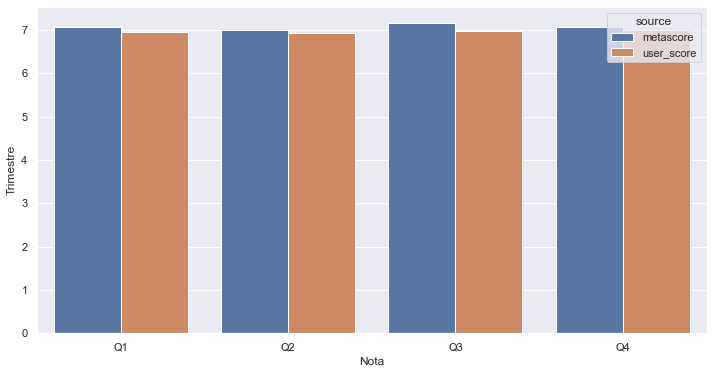

In [151]:
plt.figure(figsize=(12,6))
ax = sns.barplot(data=h4_games_df, x='release_quarter', y='score', hue='source')
ax.set_xlabel('Nota')
ax.set_ylabel('Trimestre')
plt.show()

### H11 - Qual o número de games produzidos para cada plataforma do Dataset? Esses valores indicam qual porcentagem do total?

In [152]:
h11_games_df = games_df.groupby(["manufacturer", 'platform'])[['title']].count().sort_values(by='title')
h11_games_df['percentage'] = (h11_games_df['title'] / h11_games_df['title'].sum() * 100).round(2)
h11_games_df.reset_index(inplace=True)

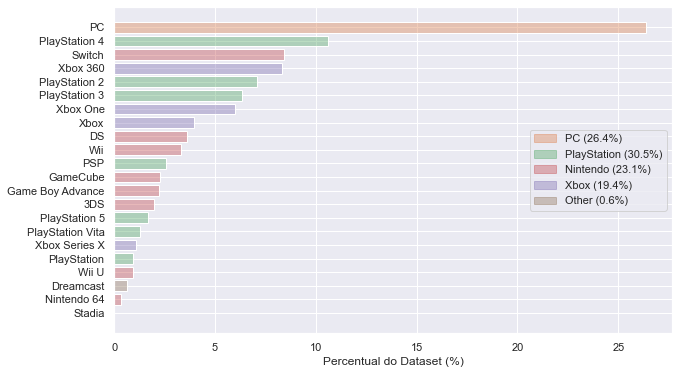

In [153]:
from matplotlib.colors import to_rgba
manufacturer_color = {
    'PC' : to_rgba('C1', 0.4),
    'PlayStation' : to_rgba('C2', 0.4),
    'Nintendo' : to_rgba('C3', 0.4),
    'Xbox' : to_rgba('C4', 0.4),
    'Other' : to_rgba('C5', 0.4)
}

plt.figure(figsize=(10,6))

plt.barh(
    data=h11_games_df, 
    y='platform', 
    width='percentage',
    color= h11_games_df['platform'].map(platform_manufacturer).map(manufacturer_color)
)
plt.xlabel('Percentual do Dataset (%)')

handles = []
for manuf, color in manufacturer_color.items():
    label = f'{manuf} ({ h11_games_df[h11_games_df["manufacturer"] == manuf].title.sum() / h11_games_df.title.sum() :.1%})'
    patch = mpatches.Patch(color= color, label= label)
    handles.append(patch)
_= plt.legend(handles= handles, loc= 'center right')

### H14 - Qual a proporção de cada tipo de classificação atribuída aos games? Qual a porcentagem do total de cada uma?

Agrupando os dados e realizar a contagem de cada ocorrência das classificações. Após isso, vamos calcular a porcentagem de cada um em relação ao total.

In [154]:
# Contando ocorrências de cada classificação:
classification_count = (games_df
                        .groupby('classification')[['classification']]
                        .count()
                        .unstack()
                        .reset_index()
                        .drop('level_0', axis=1)
                        .rename(columns={0: 'quantity'})
                        .sort_values(by='quantity', ascending=False))

classification_count

classification  quantity
2       Mixed or Average     10222
0    Generally Favorable      8011
1  Generally Unfavorable      1211
4      Universal Acclaim       569
3   Overwhelming Dislike         9

In [155]:
# Inserindo porcentagem do total:
classification_count['%_total'] = round((classification_count['quantity']/games_df.shape[0]) * 100, 2)

(classification_count
 .style
 .hide(axis='index')
 .format({'%_total': '{:.2f}%'}))

Temos que mais da metade dos games composta por 51.05% do total, recebeu a classificação de **Mixed or Average Reviews**. Curiosamente, temos apenas 9 registros totalizando 0.04% do total de games que receberam a pior classificação, **Overwhelming Dislike**.

Plotamos um gráfico para melhor visualização dos dados.

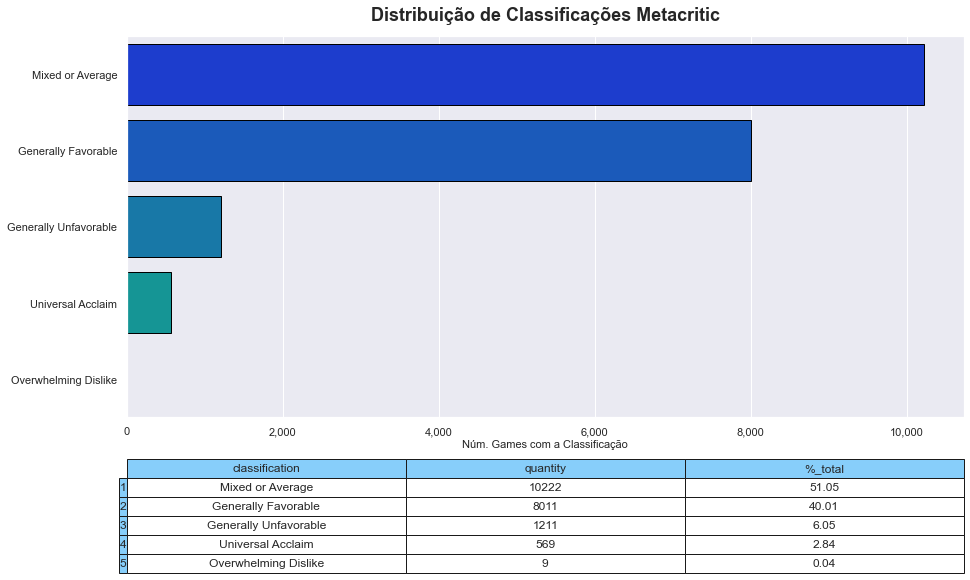

In [156]:
# Definindo parâmetros de tamanho:
fig, ax = plt.subplots(figsize=(15, 7))

# Criando o barplot:
sns.barplot(data=classification_count, 
            x='quantity', 
            y='classification',
            edgecolor='black',
            palette='winter')

# Definindo título e ajustando labels nos eixos X e Y:
plt.title('Distribuição de Classificações Metacritic', 
           fontdict={'size': 18, 'weight': 'bold'}, pad=16)

plt.xlabel('Núm. Games com a Classificação', 
           fontdict={'size': 11}, labelpad=3)

plt.ylabel('')

# Formatando valores do eixo X para ter uma vírgula:
ax.get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda number, char: format(int(number), ','))
    )

# Adicionando tabela com conteúdos
row_color = np.full(len(classification_count.index), 'lightskyblue')
col_color = np.full(len(classification_count.columns), 'lightskyblue')
row_index = np.arange(1,6)

data_table = plt.table(cellText=classification_count.values,
                       cellLoc='center',
                       rowLabels=row_index,
                       rowColours=row_color,
                       colLabels=classification_count.columns,
                       colColours=col_color,
                       bbox=[0, -0.41, 1, 0.3])

# Preciso aumentar a fonte da tabela
plt.show()

### H16 - Qual a discrepância entre notas dos 10 jogos melhor avaliados pelos usuários e pelo Metacritic?

Filtramos os dados e buscar apenas pelos 10 mais bem avaliados; após isso, inserimos uma nova coluna nesses dados apontando a variação entre as notas do Metascore e dos usuários.

- Pelo **User Score**

In [157]:
# Coletando os 10 registros com notas mais altas dos usuários:
user_top_10 = (games_df.loc[:, ['title', 'platform', 'user_score',
                                  'release_year', 'metascore', 'classification']]
               .sort_values('user_score', ascending=False)
               .head(10)
               .reset_index()
               .drop('id', axis=1))

Criamos a nova coluna com variações das avaliações. Os valores da coluna **Metascore** foram dividos por 10 para ficarem na mesma escala de 0 a 10 das notas dos usuários.

In [158]:
# Criando nova variável de variação dos dados:
user_top_10['variation'] = (user_top_10['user_score'] - (user_top_10['metascore']/10)).abs()

# Redefinindo index para iniciar por 1 em vez de 0:
user_top_10.index += 1

# Mostrando dados finais:
(user_top_10
 .style
 .highlight_max(subset='user_score', color='#39fc03')
 .highlight_max(subset='variation', color='#a82620')
 .highlight_min(subset='user_score', color='#a82620')
 .highlight_min(subset='variation', color='#39fc03')
 .format('{:.1f}', subset='user_score')
 .format('{:.1f}', subset='variation'))

Temos que a avaliação dos usuários se mantém bem consistente (tendo apenas 0.1 pontos de variação entre as notas minimas e máximas), porém, as notas do Metascore apresentam diversas avaliações mistas sobre a unanimidade positiva dos User_scores:

**Variação das Notas**

- User_score: 0.1

- Metascore: 2.9

A variação dos valores no Metascore é de 29, porém foi anotado como 2.9 pois estamos considerando os dados das duas variáveis na mesma escala (0 a 10).

A maior dispariedade entre notas dos usuários e do Metacritic pertence ao game **Metal Torrent**, cuja nota de usuário é de 9.6 porém o Metascore é de 62, tendo a variação de 3.4 pontos considerando a coluna metacritic como indo de 0 a 10.

O game mais concordado entre ambas as partes em sua qualidade, são **Resident Evil 3: Nemesis** com 9.6 na nota de usuário e 91 no Metascore, e **Resident Evil (2002)**, com 9.6 na nota de usuário e 91 no Metascore, tendo variações de 0.5 pontos considerando a coluna metacritic como indo de 0 a 10.

- Pelo **Metascore**

In [159]:
metascore_top_10 = (games_df.loc[:, ['title', 'platform', 'release_year', 
                                       'user_score', 'metascore', 'classification']]
               .sort_values('metascore', ascending=False)
               .head(10)
               .reset_index()
               .drop('id', axis=1))

In [160]:
# Criando nova variável de variação dos dados:
metascore_top_10['variation'] = (metascore_top_10['metascore']/10) - (metascore_top_10['user_score']).abs()

# Redefinindo index para iniciar por 1 em vez de 0:
metascore_top_10.index += 1

# Mostrando dados finais:
(metascore_top_10
 .style
 .highlight_max(subset='metascore', color='#39fc03')
 .highlight_max(subset='variation', color='#a82620')
 .highlight_min(subset='metascore', color='#a82620')
 .highlight_min(subset='variation', color='#39fc03')
 .format('{:.1f}', subset='user_score')
 .format('{:.1f}', subset='variation'))

Temos que a avaliação do Metascore se mantém bem consistente também (tendo 2 pontos de variação entre as notas minimas e máximas), porém, similarmente porém inversamente a situação do User_score, as avaliações dos usuários varia bastante, apresentando diversas avaliações mistas sobre a unanimidade positiva dos Metascores:

**Variação das Notas**

- User_score: 2.6

- Metascore: 0.2

A variação dos valores no Metascore é de 2, porém foi anotado como 0.2 pois estamos considerando os dados das duas variáveis na mesma escala (0 a 10).

A maior dispariedade entre notas dos usuários e do Metacritic pertence ao game **NFL 2K1**, cuja nota de usuário é de apenas 6.3 porém o Metascore é de 97, tendo a variação de 3.4 pontos considerando a coluna metacritic como indo de 0 a 10.

O game mais concordado entre ambas as partes em sua qualidade, são **The Legend of Zelda: Ocarina of Time**, cuja nota de usuário é de 9.1 e o Metascore é de 99 com e **Super Mario Odyssey**, ambos com variação de 0.8 pontos considerando a coluna metacritic como indo de 0 a 10.

### H17 -  Qual a discrepância entre notas dos 10 jogos pior avaliados pelos usuários e pelo Metacritic?

- Pelo **User Score**

In [161]:
user_bottom_10 = (games_df.query('user_score != -1')[['title', 'platform', 'release_year', 
                                                        'user_score', 'metascore', 'classification']]
               .sort_values('user_score', ascending=True)
               .head(10)
               .reset_index())

# Criando nova variável de variação dos dados:
user_bottom_10['variation'] = (user_bottom_10['user_score'] - (user_bottom_10['metascore']/10)).abs()

# Redefinindo index para iniciar por 1 em vez de 0:
user_bottom_10.index += 1

# Mostrando dados finais:
(user_bottom_10
 .style
 .highlight_max(subset='user_score', color='#39fc03')
 .highlight_max(subset='variation', color='#a82620')
 .highlight_min(subset='user_score', color='#a82620')
 .highlight_min(subset='variation', color='#39fc03')
 .format('{:.1f}', subset='user_score')
 .format('{:.1f}', subset='variation'))

Temos uma variação maior nas piores notas aferidas pelos usuários (tendo 0.6 pontos de variação entre as notas mínimas e máximas). Essa tendência também é percebida no Metascore, onde temos uma alta variação:

**Variação das Notas**

- User_score: 0.6

- Metascore: 3.0

A variação dos valores no Metascore é de 30, porém foi anotado como 3.9 pois estamos considerando os dados das duas variáveis na mesma escala (0 a 10).

A maior dispariedade entre notas dos usuários e do Metacritic pertence ao game **Tom Clancy's The Division 2: Warlords of New York**, cuja nota de usuário é de 0.9 porém o Metascore é de 68, tendo uma variação de 7 pontos considerando a escala do Metascore como sendo de 0 a 10.

O game mais concordado entre ambas as partes em sua baixa qualidade, é  **Grand Theft Auto: The Trilogy - The Definitive Edition**, cuja nota de usuário é de 0.6 e o Metascore é de 70, tendo uma variação de 4.3 pontos considerando a escala do Metascore como sendo de 0 a 10.

Se ajustarmos as escalas de ambas as notas para serem de 0 a 10, temos um cenário interessante, onde as críticas parecem ter sido muito mais "leves" em suas avaliações do que os usuários para o Grand Theft Auto: The Trilogy - The Definitive Edition:

- Notas dos usuários: 0.6

- Notas dos críticos: 4.9

Temos que a critica assimilou uma nota maior na média para o game 8 vezes maior do que as notas disponíveis pelos usuários, mesmo esse sendo o game de maior acordo entre ambas as partes de sua má qualidade.

- Pelo **Metascore**

In [162]:
metascore_bottom_10 = (games_df.loc[:, ['title', 'platform', 'release_year', 
                                       'user_score', 'metascore', 'classification']]
               .sort_values('metascore', ascending=True)
               .head(10)
               .reset_index())

# Criando nova variável de variação dos dados:
metascore_bottom_10['variation'] = (metascore_bottom_10['metascore']/10) - (metascore_bottom_10['user_score']).abs()

# Redefinindo index para iniciar por 1 em vez de 0:
metascore_bottom_10.index += 1

# Mostrando dados finais:
(metascore_bottom_10
 .style
 .highlight_max(subset='metascore', color='#39fc03')
 .highlight_max(subset='variation', color='#39fc03')
 .highlight_min(subset='metascore', color='#a82620')
 .highlight_min(subset='variation', color='#a82620')
 .format('{:.1f}', subset='user_score')
 .format('{:.1f}', subset='variation'))

Temos uma variação ainda maior nas piores notas aferidas pelo Metascore (tendo 9 pontos de variação entre as notas mínimas e máximas). Essa tendência também é percebida no User_score, onde temos uma alta variação:

**Variação das Notas**

- User_score: 3.1

- Metascore: 0.9

A variação dos valores no Metascore é de 9, porém foi anotado como 0.9 pois estamos considerando os dados das duas variáveis na mesma escala (0 a 10).

A maior dispariedade entre notas dos usuários e do Metacritic pertence ao game **Yaris**, com nota de usuário de 4.4 e Metascore de 17, possuindo assim uma variação de 2.7 pontos considerando a variável Metascore como indo de 0 a 10. 

O game mais concordado entre ambas as partes em sua baixa qualidade é são **Ride to Hell: Retribution** e **Alone in the Dark: Illumination**, ambos com nota de usuário de 1.3 e Metascore de 19, possuíndo uma variação de 0.6 pontos considerando a variável Metascore como indo de 0 a 10. 

In [201]:
h19_games_df = games_df.groupby(['release_month', 'release_year']).count().sort_values(by=['release_year','release_month'], ascending=[True, True])
h19_games_df.reset_index(inplace=True)
h19_games_df[['release_month', 'release_year']] = h19_games_df[['release_month', 'release_year']].astype(str)
h19_games_df['release_year_month'] = h19_games_df[['release_year','release_month']].apply("-".join, axis=1)
h19_games_df.drop(columns=['release_month', 'release_year', 'metascore', 'platform', 'release_date', 'sort_no', 'summary', 'title','user_score', 'release_quarter', 'release_day'], inplace=True)
h19_games_df = h19_games_df.append(h19_games_df.append(h19_games_df.append(h19_games_df.append(h19_games_df))))
h19_games_df.reset_index(drop=True,inplace=True)
h19_games_df[['platform','count_of_released_games']] = np.nan
h19_games_df.index += 1
h19_games_df

C:\Users\PICHAU\AppData\Local\Temp/ipykernel_11820/1536109566.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PICHAU\AppData\Local\Temp/ipykernel_11820/1536109566.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\PICHAU\AppData\Local\Temp/ipykernel_11820/1536109566.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



classification  manufacturer  classification_hue release_year_month  \
1                  1             1                   1             1995-4   
2                  1             1                   1             1996-1   
3                  2             2                   2             1996-2   
4                  1             1                   1             1996-3   
5                  1             1                   1             1996-6   
...              ...           ...                 ...                ...   
1601              89            89                  89            2022-10   
1602              75            75                  75            2022-11   
1603              45            45                  45            2022-12   
1604              41            41                  41             2023-1   
1605               2             2                   2             2023-2   

      platform  count_of_released_games  
1          NaN                      NaN  
2          NaN                      NaN  
3          NaN                      NaN  
4          NaN                      NaN  
5          NaN                      NaN  
...        ...                      ...  
1601       NaN                      NaN  
1602       NaN                      NaN  
1603       NaN                      NaN  
1604       NaN                      NaN  
1605       NaN                      NaN  

[1605 rows x 6 columns]

In [202]:
h19_games_df_2 = games_df.copy()
h19_games_df_2[['release_month', 'release_year']] = h19_games_df_2[['release_month', 'release_year']].astype(str)
h19_games_df_2['release_year_month'] = h19_games_df_2[['release_year','release_month']].apply("-".join, axis=1)

platform_list = ['PC', 'PlayStation 4', 'Switch', 'Xbox 360', 'PlayStation 2']

sum_released_games_number = 0
platform = 'PC'
for index, row in h19_games_df.iterrows():
    if index % 321 == 0 and index // 321 < 5:
        platform = platform_list[index//321]
        sum_released_games_number = 0
    year_month = row['release_year_month']
    sum_released_games_number += h19_games_df_2.query(f'release_year_month == "{year_month}" & platform == "{platform}"').shape[0]
    h19_games_df.loc[index, 'platform'] = platform
    h19_games_df.loc[index, 'count_of_released_games'] = sum_released_games_number
            
h19_games_df

classification  manufacturer  classification_hue release_year_month  \
1                  1             1                   1             1995-4   
2                  1             1                   1             1996-1   
3                  2             2                   2             1996-2   
4                  1             1                   1             1996-3   
5                  1             1                   1             1996-6   
...              ...           ...                 ...                ...   
1601              89            89                  89            2022-10   
1602              75            75                  75            2022-11   
1603              45            45                  45            2022-12   
1604              41            41                  41             2023-1   
1605               2             2                   2             2023-2   

           platform  count_of_released_games  
1                PC                      1.0  
2                PC                      2.0  
3                PC                      4.0  
4                PC                      4.0  
5                PC                      5.0  
...             ...                      ...  
1601  PlayStation 2                   1421.0  
1602  PlayStation 2                   1421.0  
1603  PlayStation 2                   1421.0  
1604  PlayStation 2                   1421.0  
1605  PlayStation 2                   1421.0  

[1605 rows x 6 columns]

In [203]:
fig = px.bar(h19_games_df,x='platform', y="count_of_released_games", animation_frame='release_year_month', range_y=[0, 7000])
fig.show()